# 00.Importing Libraries

In [32]:
!pip install metpy --quiet

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from metpy.calc import heat_index
from metpy.units import units

# 01.Helpers

### 01.01 Constants

In [34]:
features_datasus = ["hospitalizations", "average_stay", "deaths", "mortality_rate"]

### 01.02 Functions

In [35]:
def timelag(df, lag, features):
    for feature in features:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df

# 02.Importing Datasets

In [36]:
# Assigning the raw data path
urlINMET = "https://raw.githubusercontent.com/ThierrryScotto/trabalho_pratico/refs/heads/main/datasets/INMET.csv"
urlSUS = "https://raw.githubusercontent.com/ThierrryScotto/trabalho_pratico/refs/heads/main/datasets/datasus_por_local_internacao_v2.csv"

In [37]:
# Reading the INMET Dataset and  removing the last column Unnamed:19
datasetINMET = pd.read_csv(urlINMET, sep=";",decimal = ',')[:-1]
datasetINMET.head(2)

,DATA,HORA,PRECIPITACAO_TOTAL_HORARIO_MM,PRESSAO_ATMOSFERICA_NIVEL_ESTACAO_HORARIA_MB,PRESSAO_ATMOSFERICA_MAX.NA_HORA_ANT_AUT_MB,PRESSAO_ATMOSFERICA_MIN_NA_HORA_ANT_AUT_MB,RADIACAO_GLOBAL_KJ_m2,TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C,TEMPERATURA_PONTO_DE_ORVALHO_C,TEMPERATURA_MAXIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_MINIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MAX_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MIN_NA_HORA_ANT_AUT_C,UMIDADE_REL_MAX_NA_HORA_ANT_AUT_%,UMIDADE_REL_MIN_NA_HORA_ANT_AUT_%,UMIDADE_RELATIVA_DO_AR_HORARIA_%,VENTO_DIRECAO_HORARIA_GR,VENTO_RAJADA_MAXIMA_M/S,VENTO_VELOCIDADE_HORARIA_M/S,Unnamed: 19
0,2000-09-22,22:00,0.0,1014.1,1014.3,1014.0,13.0,15.7,9.8,17.7,15.6,10.9,9.8,70.0,62.0,68.0,106.0,6.3,2.4,NaN
1,2000-09-22,21:00,0.0,1014.3,1014.3,1014.0,448.0,17.8,10.7,19.8,17.8,10.7,9.4,63.0,51.0,63.0,112.0,4.7,2.2,NaN


In [38]:
# Reading the SUS Dataset
datasetSUS = pd.read_csv(urlSUS, sep=";",decimal = ',')
datasetSUS.head(2)

,Ano/mes processamento,Internacoes,Media_Permanencia,Obitos,Taxa_Mortalidade
0,..Janeiro/1998,3905,6.3,229,5.86
1,..Fevereiro/1998,3502,5.8,200,5.71


# 03.INMET Data pre-processing

In [39]:
# Selecting only features that are relevant to the problem

features = ['DATA',
            'HORA',
            'TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C',
            'RADIACAO_GLOBAL_KJ_m2',
            'UMIDADE_RELATIVA_DO_AR_HORARIA_%',
            'VENTO_VELOCIDADE_HORARIA_M/S']

datasetINMET = datasetINMET[features]

In [40]:
# Generating summary of the dataset including shape, number of non-null values in each column, data types and memory usage
print('-----------------------------------')
print('Sahpe of de dataset:')
print(datasetINMET.shape)
print('-----------------------------------')

datasetINMET.info()

-----------------------------------
Sahpe of de dataset:
(211343, 6)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211343 entries, 0 to 211342
Data columns (total 6 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   DATA                                    211343 non-null  object 
 1   HORA                                    211343 non-null  object 
 2   TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C  211100 non-null  float64
 3   RADIACAO_GLOBAL_KJ_m2                   187429 non-null  float64
 4   UMIDADE_RELATIVA_DO_AR_HORARIA_%        211095 non-null  object 
 5   VENTO_VELOCIDADE_HORARIA_M/S            211049 non-null  float64
dtypes: float64(3), object(3)
memory usage: 9.7+ MB


In [41]:
# Generating summary statistics for numerical columns in the dataset
datasetINMET.describe()

,TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C,RADIACAO_GLOBAL_KJ_m2,VENTO_VELOCIDADE_HORARIA_M/S
count,211100.000000,187429.000000,211049.000000
mean,-286.630909,-3419.157770,-350.816791
std,1725.637233,5580.226428,1843.798993
min,-9999.000000,-9999.000000,-9999.000000
25%,15.600000,-9999.000000,0.700000
50%,19.800000,70.900000,1.300000
75%,23.600000,1249.100000,2.100000
max,40.200000,3999.900000,13.300000


In [42]:
# Verifying the number of non-null values
datasetINMET.isna().sum()

DATA                                          0
HORA                                          0
TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C      243
RADIACAO_GLOBAL_KJ_m2                     23914
UMIDADE_RELATIVA_DO_AR_HORARIA_%            248
VENTO_VELOCIDADE_HORARIA_M/S                294
dtype: int64

The following problems were found in the dataset:

- Null values
- Invalid values: -9999
- Column UMIDADE_RELATIVA_DO_AR_HORARIA_% as string


## 03.01 Handling invalid values

In [43]:
## Replacing -9999.0 for null values
datasetINMET = datasetINMET.replace(-9999.0, np.nan)
## Removing any negative value and coverting to float for the case of UMIDADE_RELATIVA_DO_AR_HORARIA_%
for column in datasetINMET.columns[2:]:
    datasetINMET[column] = datasetINMET[column].apply(float).apply(lambda x: np.nan if x < 0 else x)

datasetINMET.describe()

,TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C,RADIACAO_GLOBAL_KJ_m2,UMIDADE_RELATIVA_DO_AR_HORARIA_%,VENTO_VELOCIDADE_HORARIA_M/S
count,204640.000000,110018.000000,204633.000000,203613.000000
mean,19.965574,1210.558885,76.000073,1.537382
std,5.704724,1073.118325,15.736948,1.016879
min,0.400000,0.000000,15.000000,0.000000
25%,16.100000,226.400000,65.000000,0.800000
50%,20.100000,960.150000,79.000000,1.400000
75%,23.700000,2025.875000,89.000000,2.100000
max,40.200000,3999.900000,100.000000,13.300000


## 03.02 Verifying dates

In [44]:
## Looking for missing dates

datasetINMET['DATA'] = pd.to_datetime(datasetINMET['DATA'])

start_date = datasetINMET['DATA'].min()
end_date = datasetINMET['DATA'].max()
complete_dates = pd.date_range(start=start_date, end=end_date)

missing_dates = complete_dates.difference(datasetINMET['DATA'])

print("missing dates:")
print(missing_dates)

missing dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


## 03.03 Plotting Variables of the Dataset

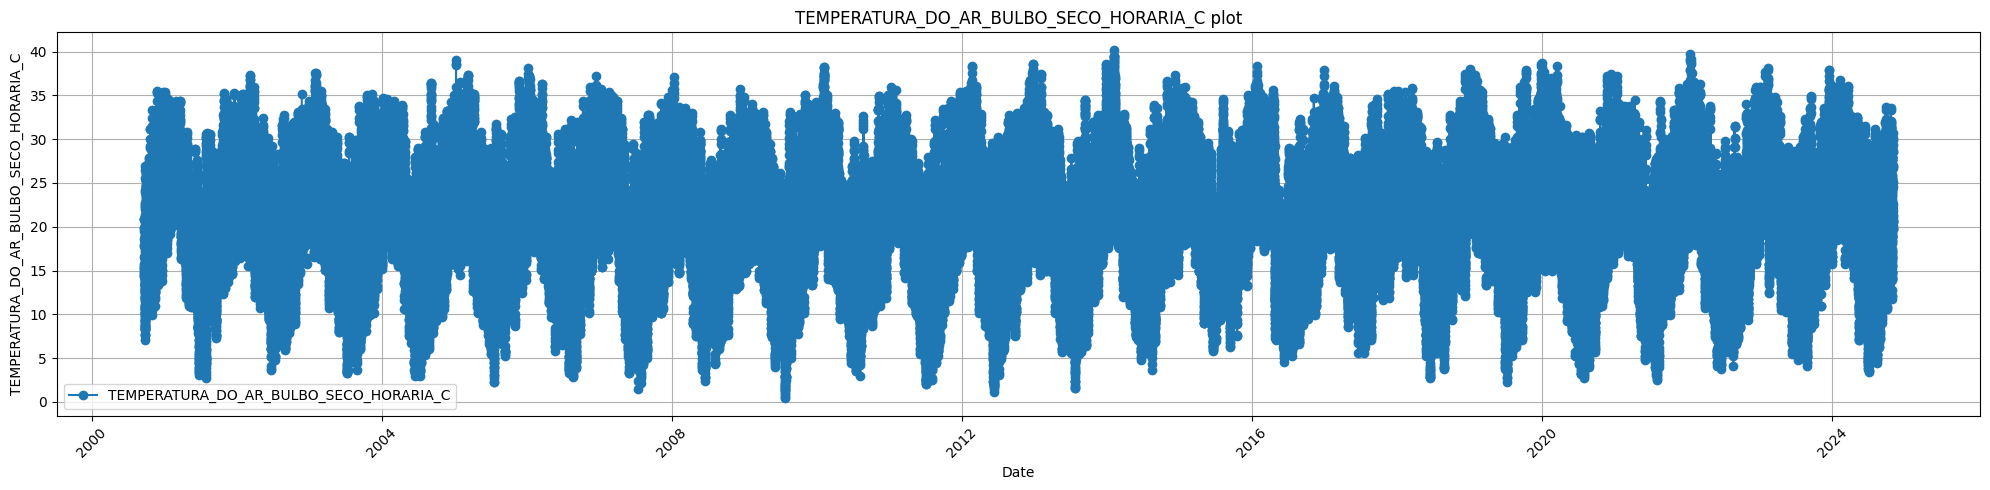

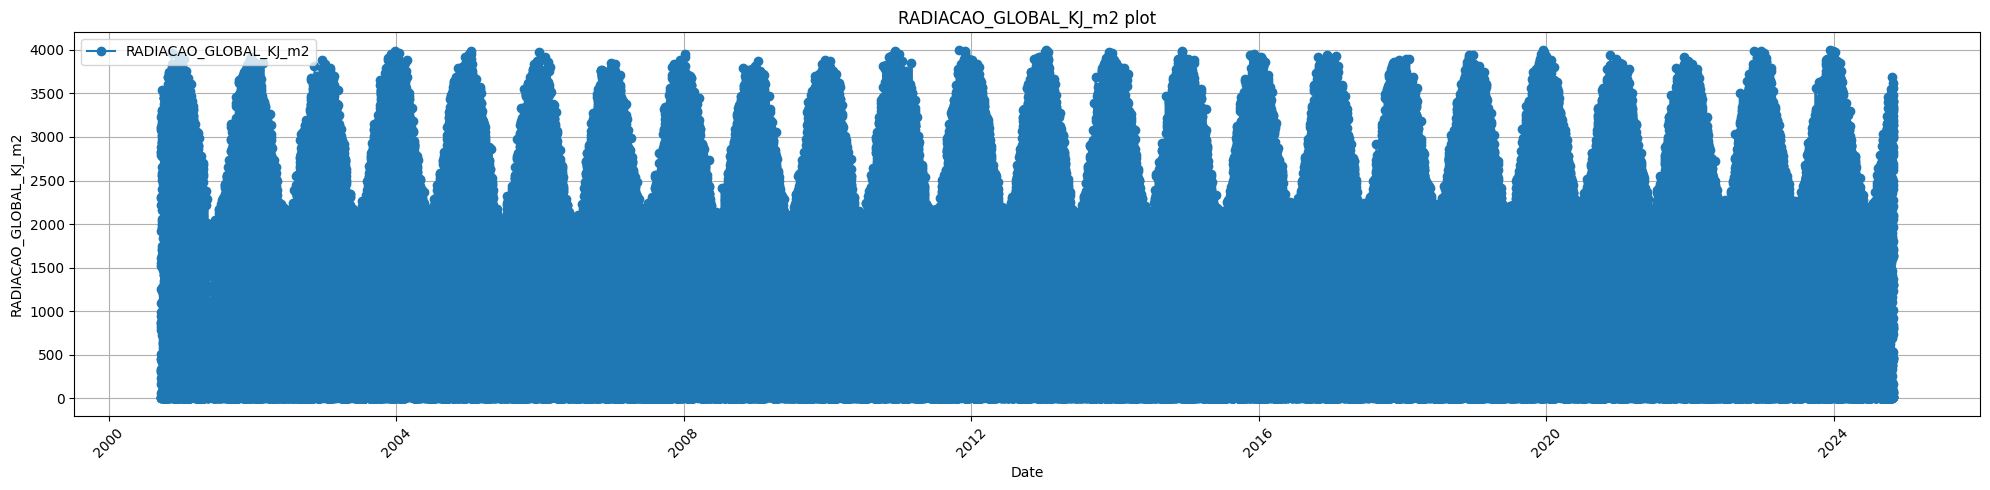

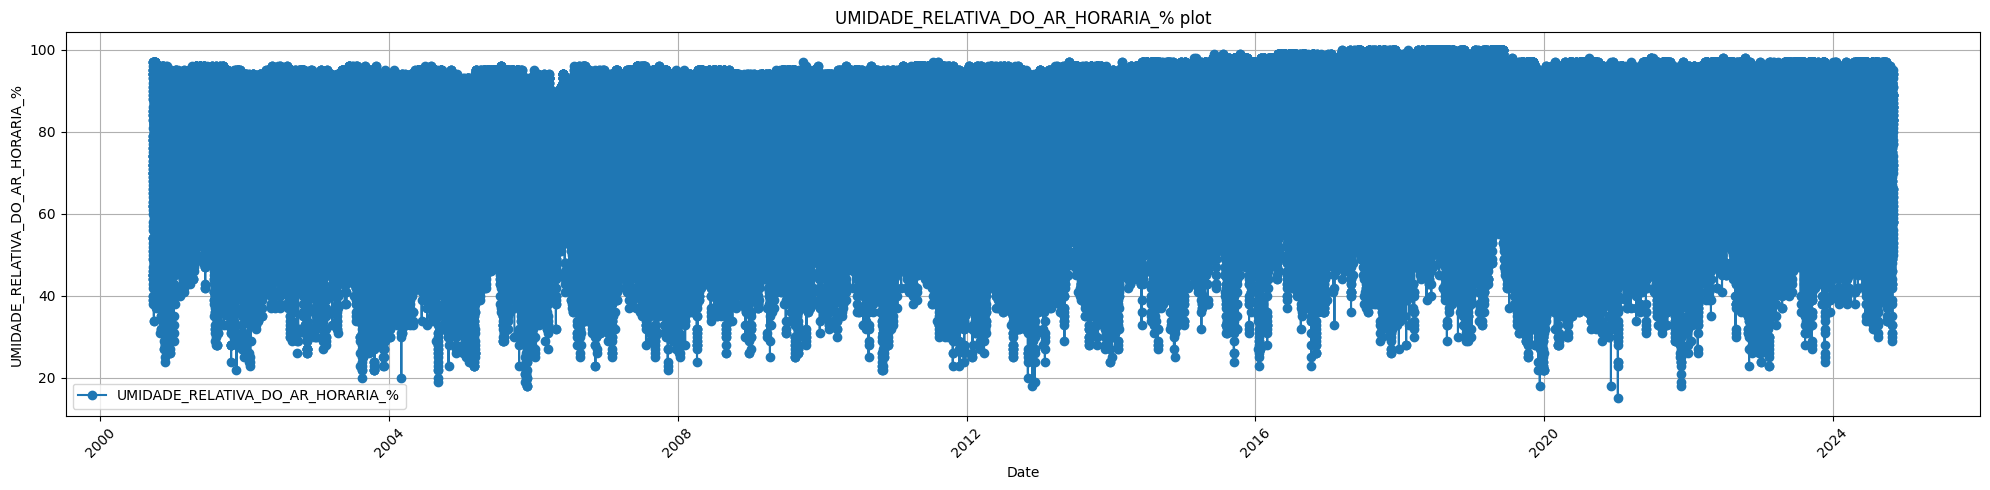

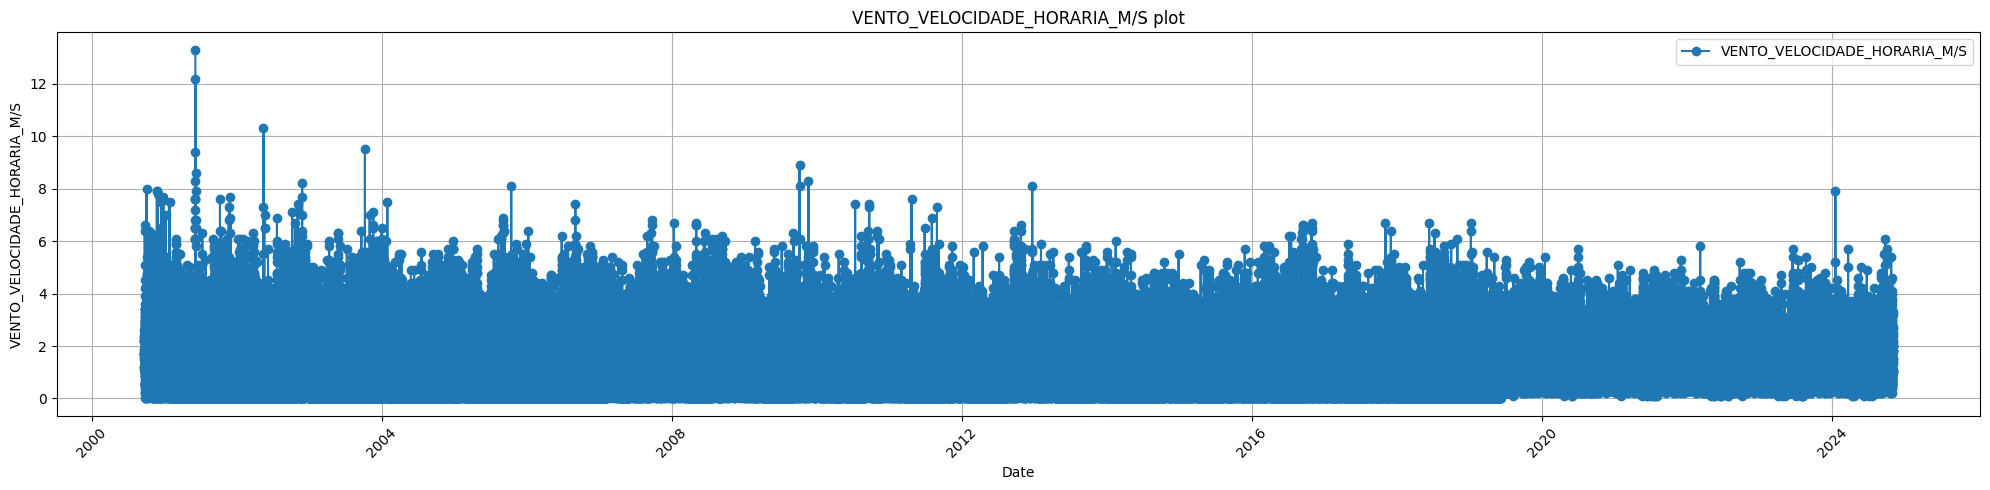

In [45]:
# Defining columns to be plotted (removing date and hour)
columns = datasetINMET.columns[2:]

# Plotting each relevant column of the dataset
for var in columns:
    plt.figure(figsize=(20, 5))
    plt.plot(datasetINMET['DATA'], datasetINMET[var], marker='o', label=var)
    plt.title(f'{var} plot')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 03.04 Handling missing data

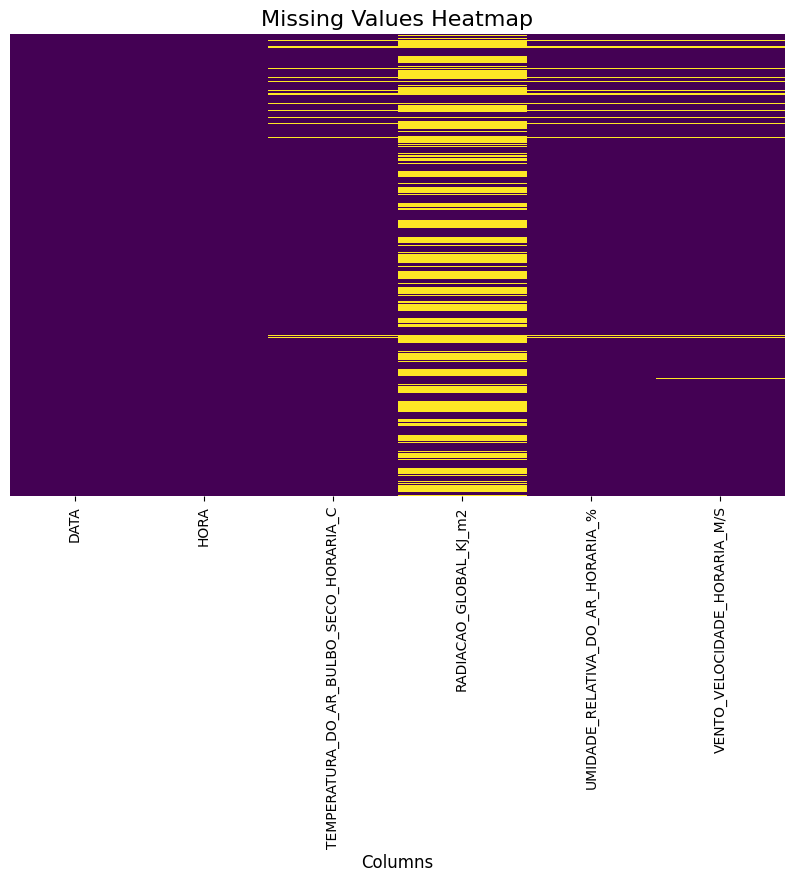

In [46]:
# Plotting a heatmap highlighting missing values
plt.figure(figsize=(10, 6))
sns.heatmap(datasetINMET.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.show()

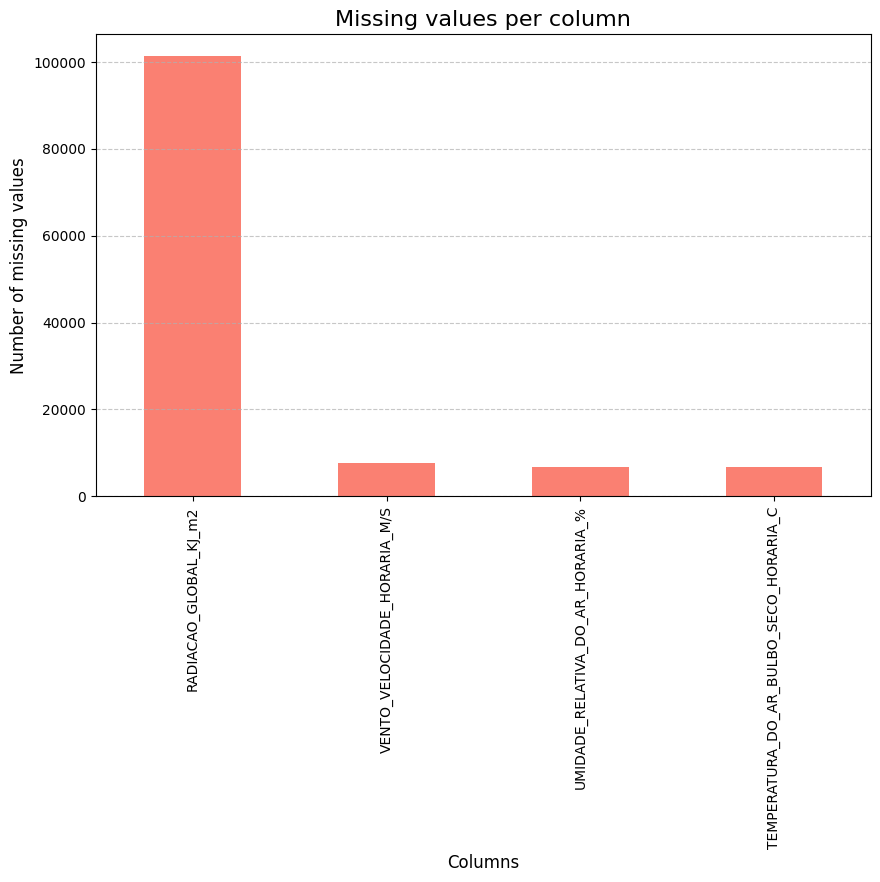


---------------------------------------------------------------------
PERCENTAGE OF MISSING DATA: 

Radiacao: 92.10%
TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C: 3.28%
UMIDADE_RELATIVA_DO_AR_HORARIA_%: 3.28%
VENTO_VELOCIDADE_HORARIA_M/S: 3.80%


In [47]:
# Plotting a bar chart of number of missing values per column
plt.figure(figsize=(10, 6))
missing_data = datasetINMET.isna().sum()
missing_data[missing_data > 0].sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('Missing values per column', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of missing values', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculationg the proportion [%] of missing values in each column of the dataset
radiation = (datasetINMET['RADIACAO_GLOBAL_KJ_m2'].isna().sum()/datasetINMET['RADIACAO_GLOBAL_KJ_m2'].count()) * 100
temp     = (datasetINMET['TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C'].isna().sum() / datasetINMET['TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C'].count()) * 100
hum  = (datasetINMET['UMIDADE_RELATIVA_DO_AR_HORARIA_%'].isna().sum() / datasetINMET['UMIDADE_RELATIVA_DO_AR_HORARIA_%'].count()) * 100
wind    = (datasetINMET['VENTO_VELOCIDADE_HORARIA_M/S'].isna().sum() / datasetINMET['VENTO_VELOCIDADE_HORARIA_M/S'].count()) * 100
print(f'')
print(f'---------------------------------------------------------------------')
print(f'PERCENTAGE OF MISSING DATA: ')
print(f'')
print(f'Radiacao: {radiation:.2f}%')
print(f'TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C: {temp:.2f}%')
print(f'UMIDADE_RELATIVA_DO_AR_HORARIA_%: {hum:.2f}%')
print(f'VENTO_VELOCIDADE_HORARIA_M/S: {wind:.2f}%')

### Solar radiation was removed after the analysis

In [48]:
datasetINMET.drop('RADIACAO_GLOBAL_KJ_m2', axis=1, inplace=True)

### Filling missing data with nearest value

In [49]:
# Using nearest interpolation to fill missing values
for column in datasetINMET.columns[2:]:
    datasetINMET[column] = datasetINMET[column].interpolate(method="nearest")
    print(f'Column {column} interpolated')

# Checking for missing values after interpolation
print('---------------------------------------------')
print('Missing values after interpolation')
print(datasetINMET.isna().sum())

Column TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C interpolated
Column UMIDADE_RELATIVA_DO_AR_HORARIA_% interpolated
Column VENTO_VELOCIDADE_HORARIA_M/S interpolated
---------------------------------------------
Missing values after interpolation
DATA                                      0
HORA                                      0
TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C    0
UMIDADE_RELATIVA_DO_AR_HORARIA_%          0
VENTO_VELOCIDADE_HORARIA_M/S              0
dtype: int64


## 03.05 EDA and Outliers

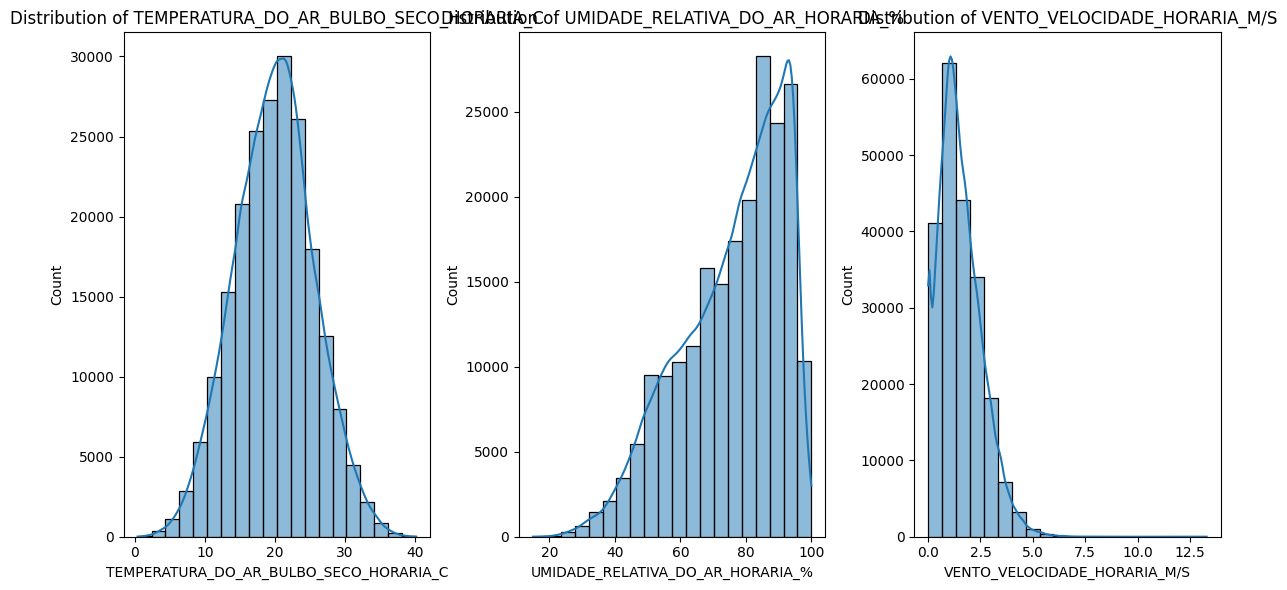

In [50]:
# Histograms
plt.figure(figsize=(12, 6))
for i, column in enumerate(datasetINMET.columns[2:], 1):
    plt.subplot(1, 3, i)
    sns.histplot(datasetINMET[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


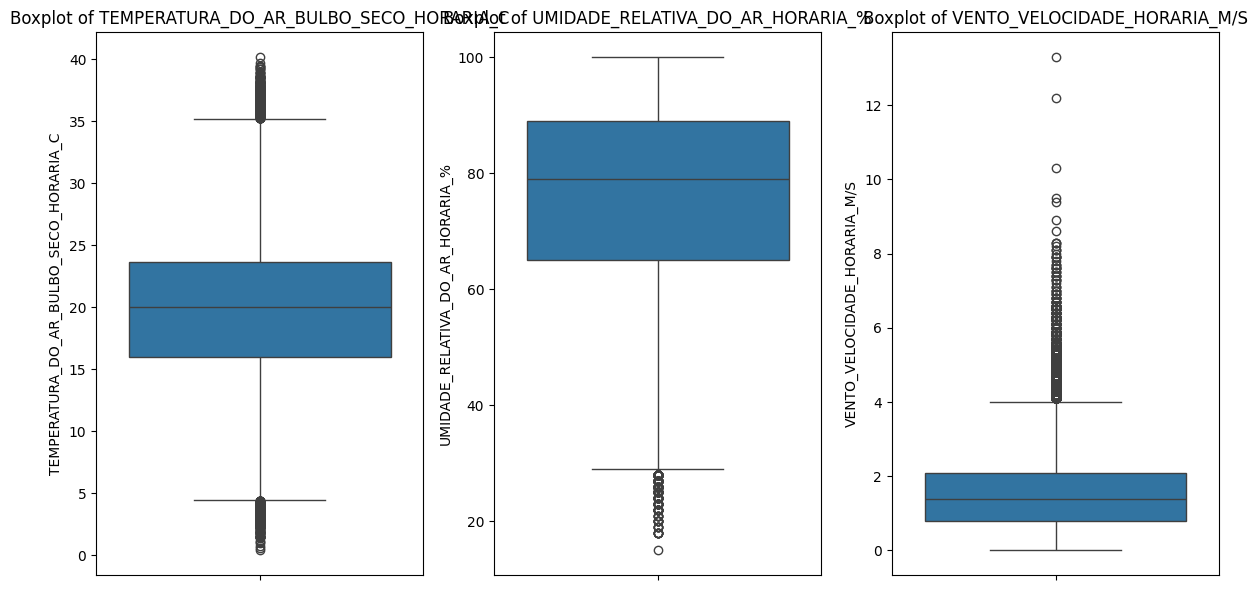

In [51]:
# Boxplots
plt.figure(figsize=(12, 6))
for i, column in enumerate(datasetINMET.columns[2:], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=datasetINMET[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


Some outliers identified but no unreasonable values, so they will be kept

## 03.06 Feature engineering

In [52]:
from metpy.calc import heat_index
from metpy.units import units

### Deriving feature HI (NWS)
https://www.wpc.ncep.noaa.gov/html/heatindex.shtml

In [53]:
# Convert from Feirenheit to celsius
temperature_fahrenheit = datasetINMET['TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C'].values * 9/5 + 32

# applying unit
temperature_fahrenheit = temperature_fahrenheit * units.degF
relative_humidity = datasetINMET['UMIDADE_RELATIVA_DO_AR_HORARIA_%'].values * units.percent

# Calculating Heat Index (Fahrenheit)
heat_index_fahrenheit = heat_index(temperature_fahrenheit, relative_humidity)

# Convert results back to celsius
datasetINMET['heat_index_f'] = heat_index_fahrenheit.round(2)
datasetINMET['heat_index'] = ((datasetINMET['heat_index_f'].values - 32) * 5/9).round(2)

print(f"Heat Index (HI) in Celsius: {datasetINMET['heat_index']}\n\n")
print(f"Heat Index (HI) in fahrenheit: {datasetINMET['heat_index_f']}")

Heat Index (HI) in Celsius: 0         15.10
1         17.28
2         19.19
3         20.14
4         20.09
          ...  
211338    20.93
211339    21.13
211340    21.43
211341    22.82
211342    22.07
Name: heat_index, Length: 211343, dtype: float64


Heat Index (HI) in fahrenheit: 0         59.18
1         63.11
2         66.55
3         68.26
4         68.16
          ...  
211338    69.68
211339    70.03
211340    70.58
211341    73.08
211342    71.73
Name: heat_index_f, Length: 211343, dtype: float64


### Exploring HI

Text(0.5, 1.0, 'Disribution of heat_index')

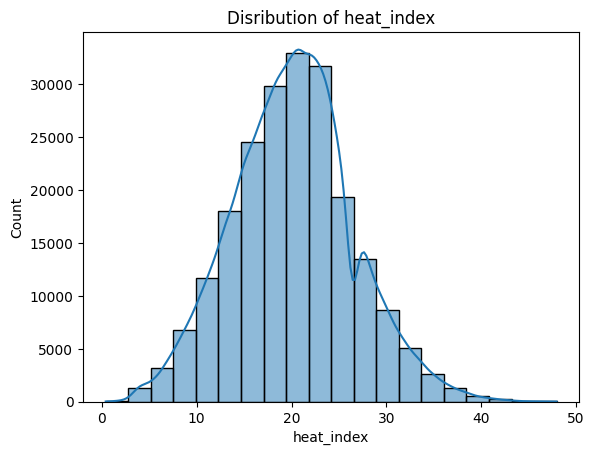

In [54]:
#plotring the distribution
sns.histplot(datasetINMET['heat_index'], kde=True, bins=20)
plt.title('Disribution of heat_index')

Text(0.5, 1.0, 'Box Plot of heat_index')

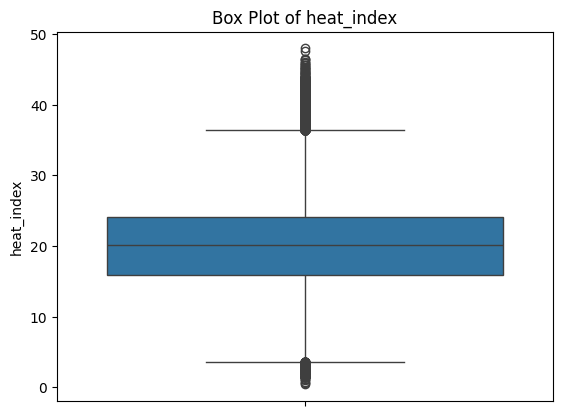

In [55]:
# Boxplots
sns.boxplot(y=datasetINMET['heat_index'])
plt.title('Box Plot of heat_index')

## 03.07 Aggregate data in monthly resolution

In [56]:
#Creating the monthly dataframe with heat_index
datasetINMET['month'] = datasetINMET['DATA'].dt.to_period('M')
datasetINMET_m = datasetINMET.groupby('month')['heat_index'].mean().to_frame()

#Creating other heat index features
datasetINMET_m['heat_index_sum'] = datasetINMET.groupby('month')['heat_index'].sum()
datasetINMET_m['heat_index_std'] = datasetINMET.groupby('month')['heat_index'].std()
datasetINMET_m['heat_index99'] = datasetINMET.groupby('month')['heat_index'].apply(lambda x: np.percentile(x, 99))
datasetINMET_m['heat_index95'] = datasetINMET.groupby('month')['heat_index'].apply(lambda x: np.percentile(x, 95))

#Creating features from original meteorological data
datasetINMET_m['temperature_mean'] = datasetINMET.groupby('month')['TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C'].mean()
datasetINMET_m['temperature_max'] = datasetINMET.groupby('month')['TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C'].max()
datasetINMET_m['temperature_min'] = datasetINMET.groupby('month')['TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C'].min()
datasetINMET_m['wind_speed_mean'] = datasetINMET.groupby('month')['VENTO_VELOCIDADE_HORARIA_M/S'].mean()
datasetINMET_m['humidity_mean'] = datasetINMET.groupby('month')['UMIDADE_RELATIVA_DO_AR_HORARIA_%'].mean()

In [57]:
datasetINMET_m

,heat_index,heat_index_sum,heat_index_std,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean
month,,,,,,,,,,
2000-09,15.300694,3304.95,5.143118,26.6810,25.0425,15.787963,26.9,7.1,1.811574,71.629630
2000-10,19.318992,14373.33,3.798117,29.4271,26.6240,19.232258,31.2,9.9,2.348118,79.541667
2000-11,21.132403,15215.33,4.569946,33.0400,29.9495,21.075833,35.5,10.9,2.215278,71.505556
2000-12,24.154261,17970.77,4.999719,37.8966,33.5380,23.575000,35.4,13.4,1.826613,70.836022
2001-01,26.316156,19579.22,4.452698,37.8471,34.6685,25.136962,35.4,17.0,1.777016,75.375000
...,...,...,...,...,...,...,...,...,...,...
2024-06,17.283889,12444.40,5.390826,29.7834,26.8025,17.371111,31.5,4.6,1.265139,80.636111
2024-07,13.313495,9905.24,4.740495,26.8167,21.7780,13.736022,28.9,3.4,1.123387,81.887097
2024-08,15.274395,11364.15,5.299870,28.9485,24.4525,15.594758,31.1,4.5,1.394892,78.956989


## 03.08 Features for Time-Lags

In [58]:
#Creating features to capture the timelag effect, values of 1, 2 and 3 months prior to each record
datasetINMET_m['lag_heat_index_1'] = datasetINMET_m['heat_index'].shift(1)
datasetINMET_m['lag_heat_index_2'] = datasetINMET_m['heat_index'].shift(2)
datasetINMET_m['lag_heat_index_3'] = datasetINMET_m['heat_index'].shift(3)

# Removing first columns of the dataset, where the time-lag features will be zero
datasetINMET_m.dropna(inplace=True)

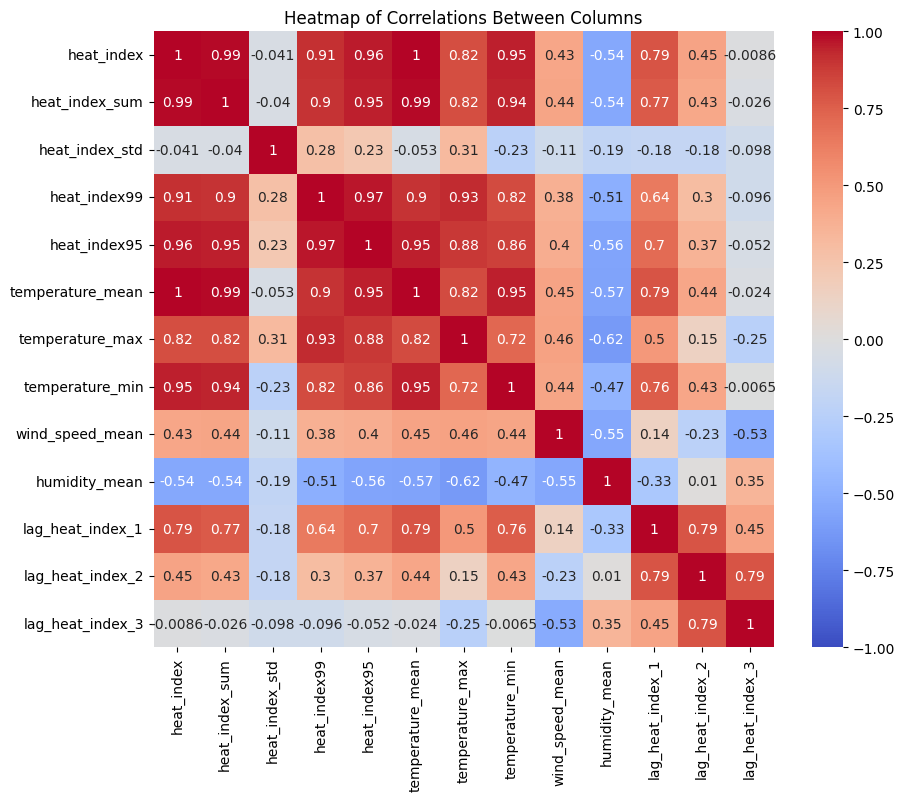

In [59]:
# Exploring the relationship between the features
plt.figure(figsize=(10, 8))
sns.heatmap(datasetINMET_m.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlations Between Columns')
plt.show()

## 03.09 Saving the Dataset

In [60]:
datasetINMET_m.index.name = 'date'
datasetINMET_m.to_csv('datasetINMET.csv', index=True)

In [61]:
# Generating summary of the dataset including shape, number of non-null values in each column, data types and memory usage
print('-----------------------------------')
print('Sahpe of de dataset:')
print(datasetINMET_m.shape)
print('-----------------------------------')

datasetINMET_m.info()

-----------------------------------
Sahpe of de dataset:
(287, 13)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 287 entries, 2000-12 to 2024-10
Freq: M
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   heat_index        287 non-null    float64
 1   heat_index_sum    287 non-null    float64
 2   heat_index_std    287 non-null    float64
 3   heat_index99      287 non-null    float64
 4   heat_index95      287 non-null    float64
 5   temperature_mean  287 non-null    float64
 6   temperature_max   287 non-null    float64
 7   temperature_min   287 non-null    float64
 8   wind_speed_mean   287 non-null    float64
 9   humidity_mean     287 non-null    float64
 10  lag_heat_index_1  287 non-null    float64
 11  lag_heat_index_2  287 non-null    float64
 12  lag_heat_index_3  287 non-null    float64
dtypes: float64(13)
memory usage: 31.4 KB


## 03.10 Final plot

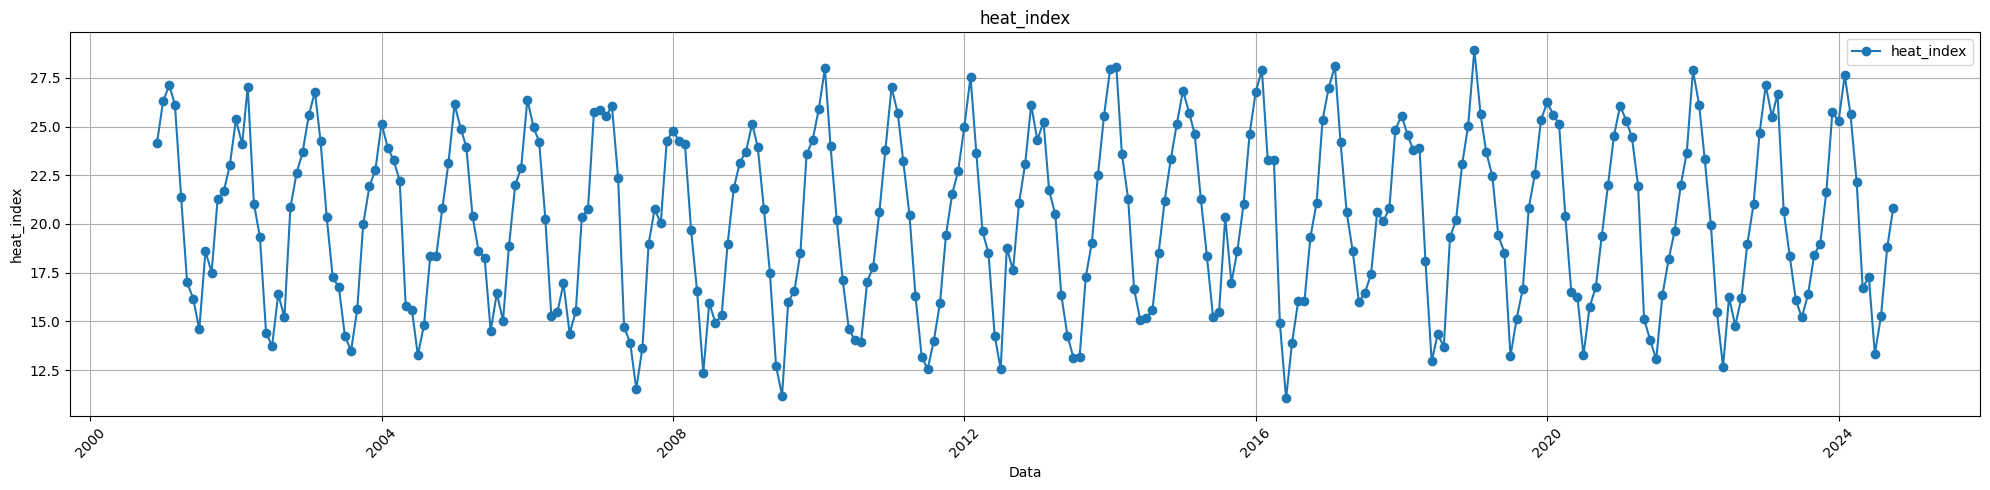

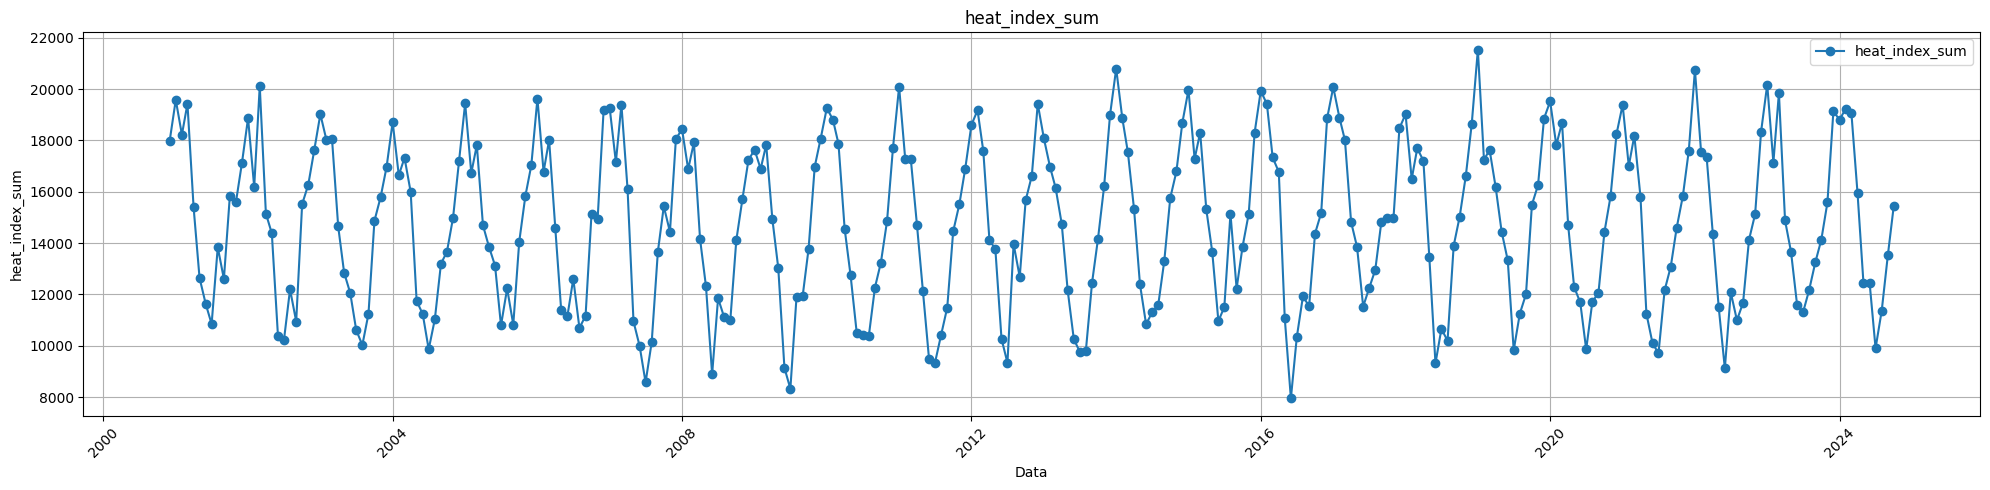

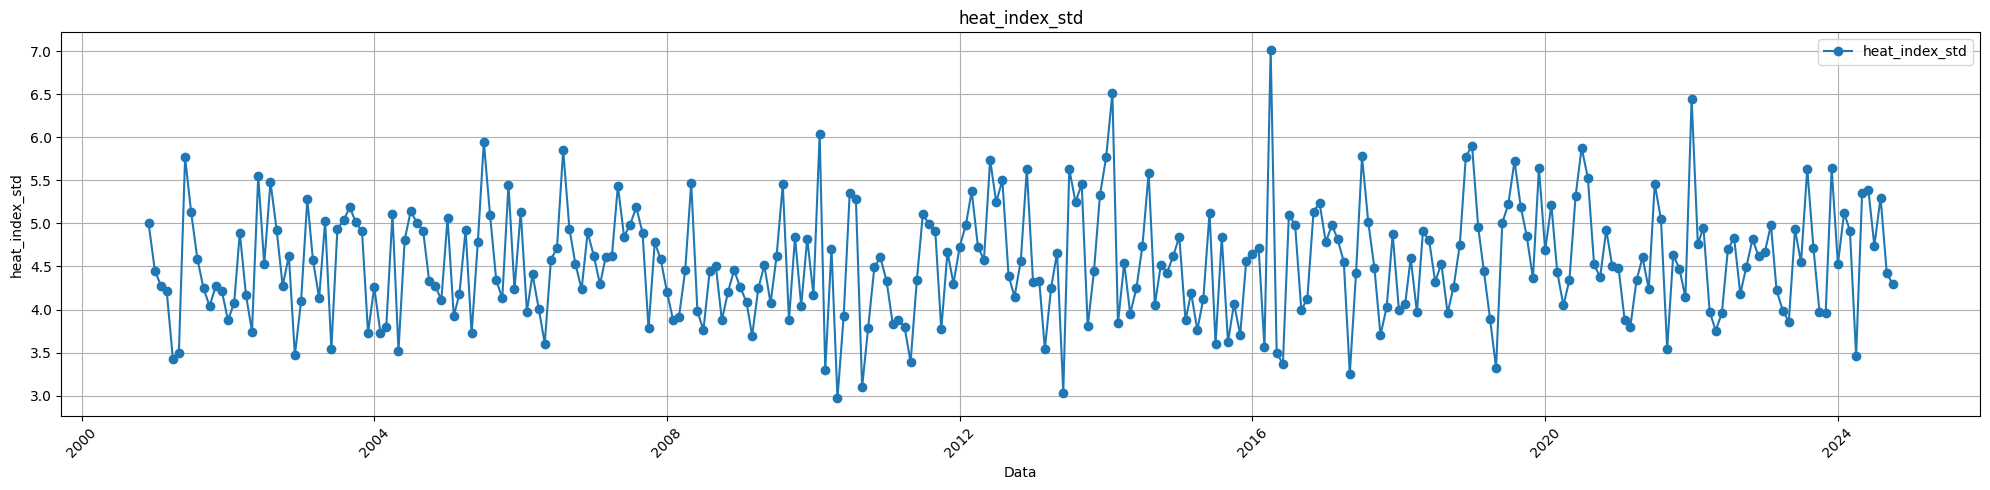

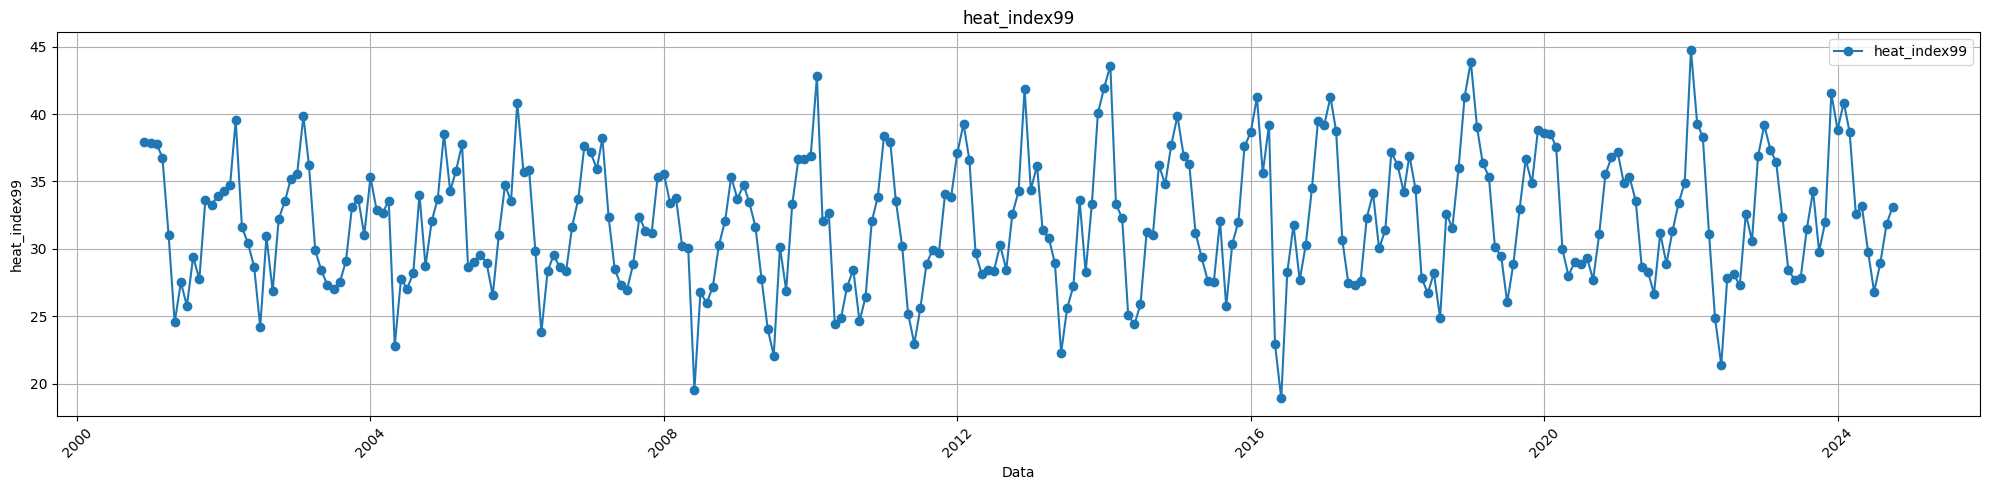

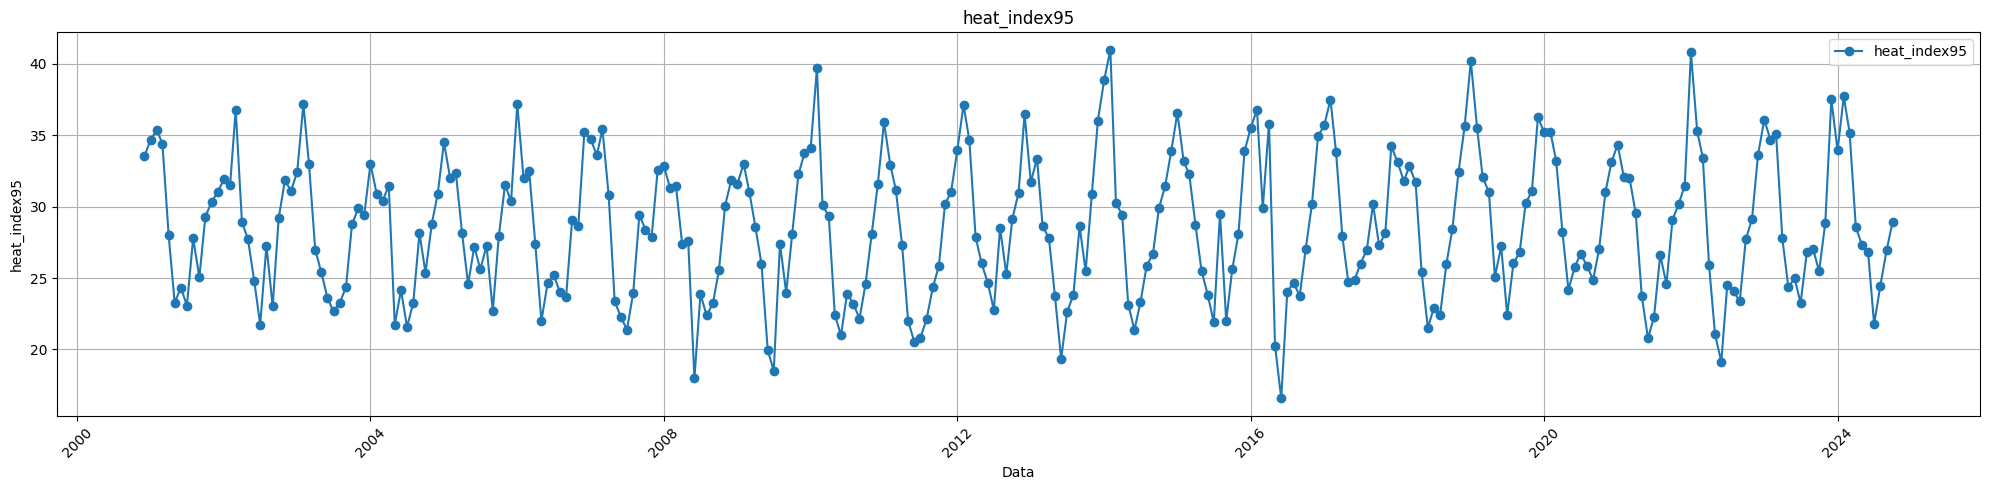

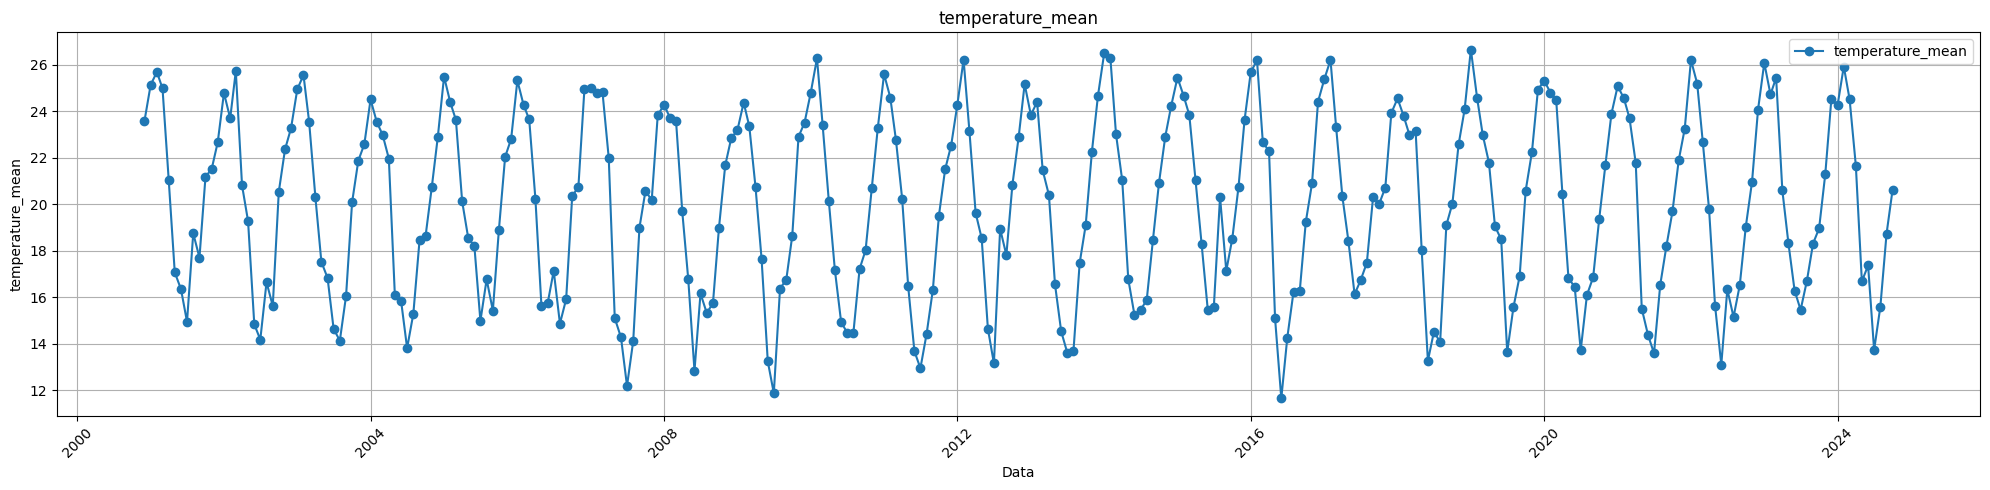

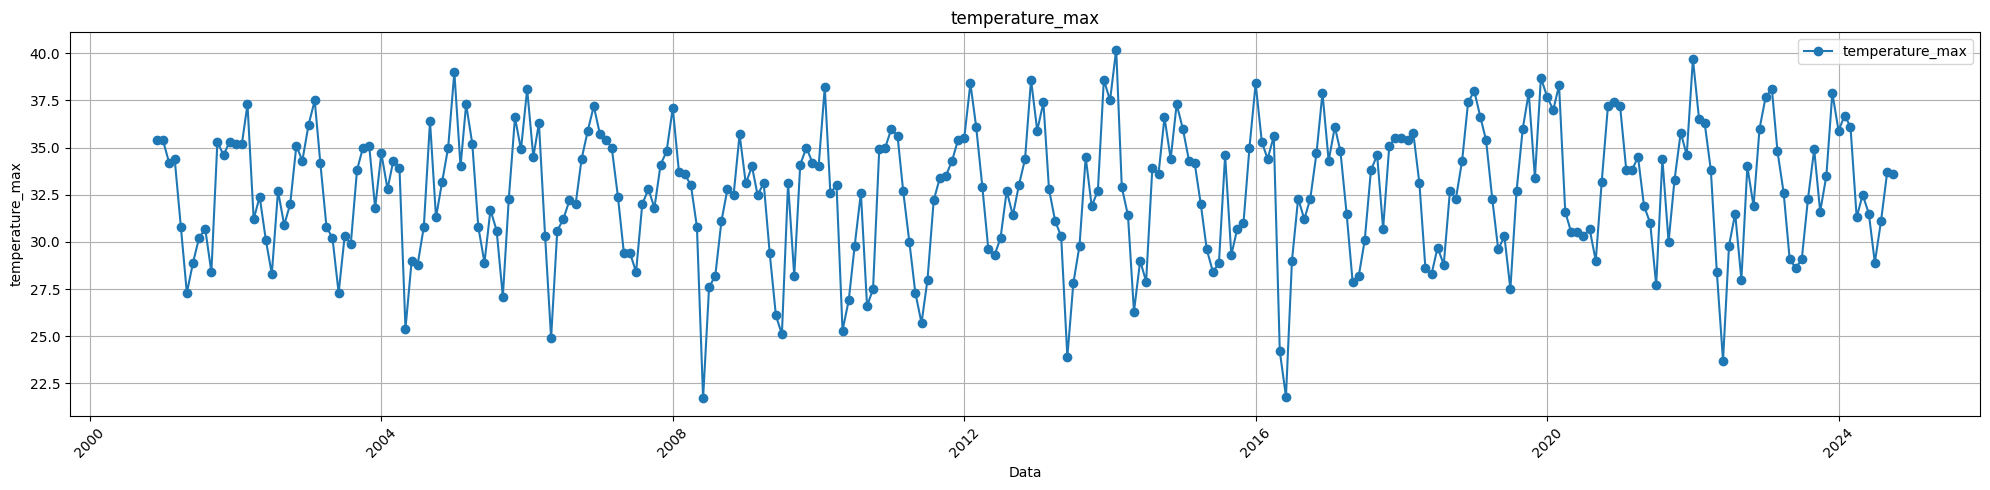

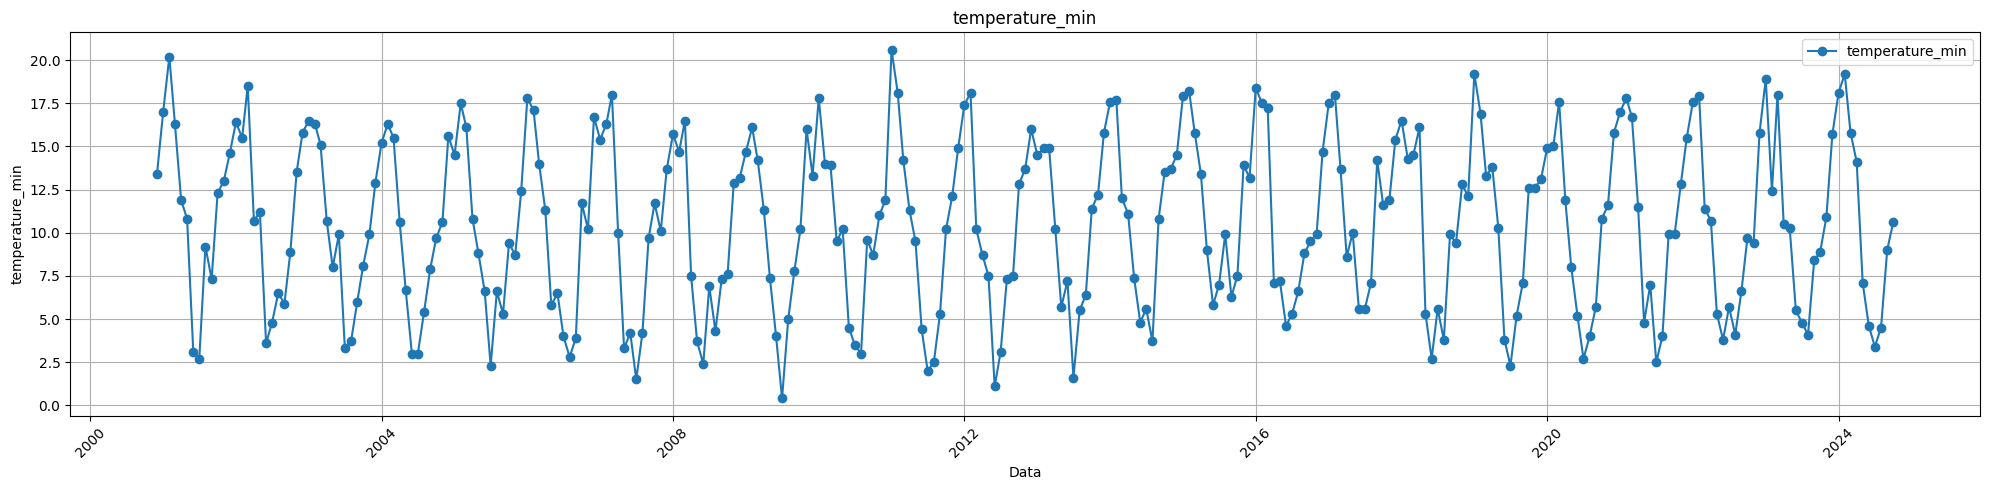

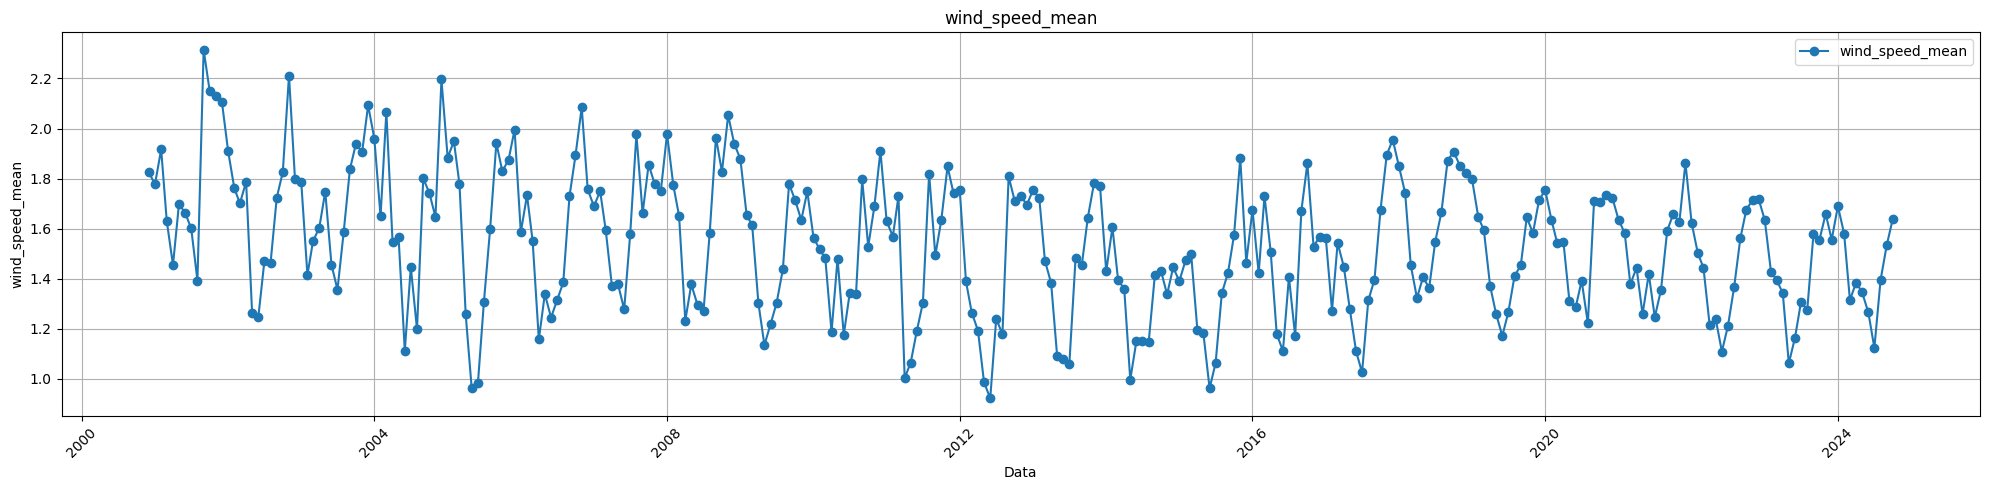

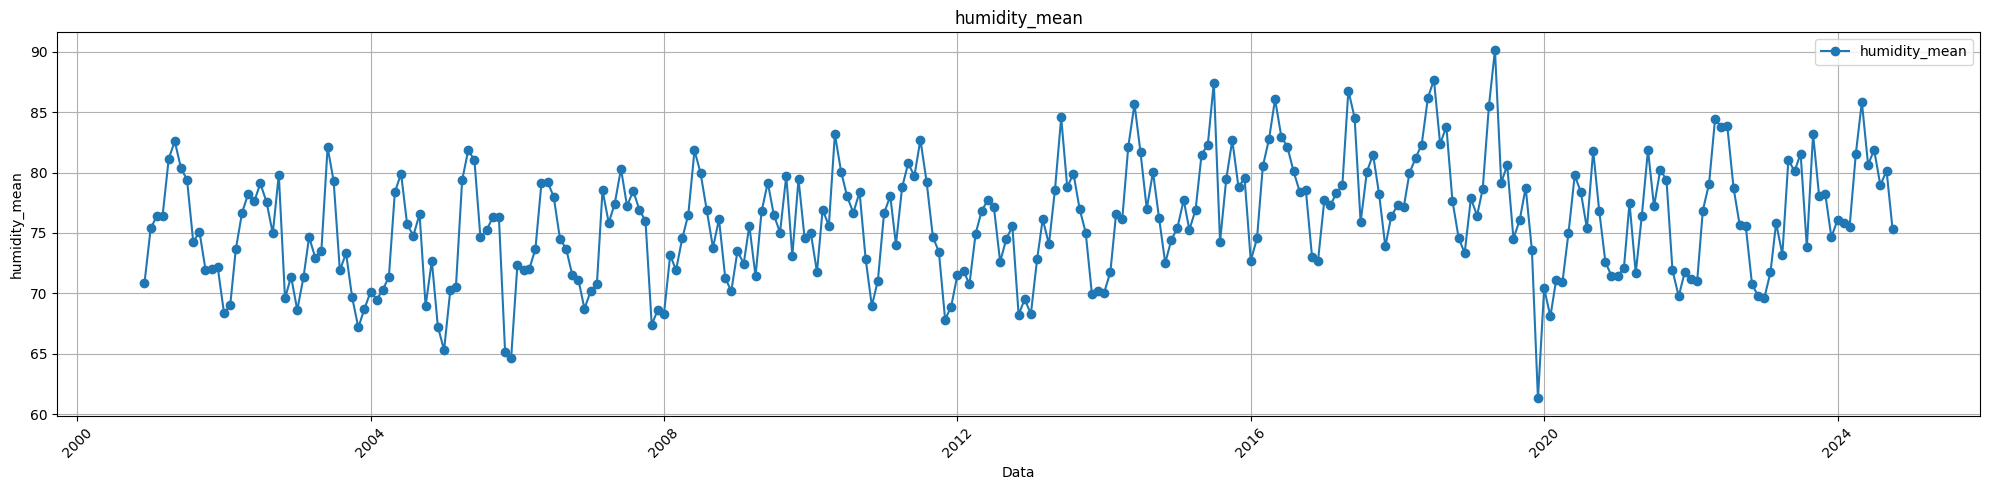

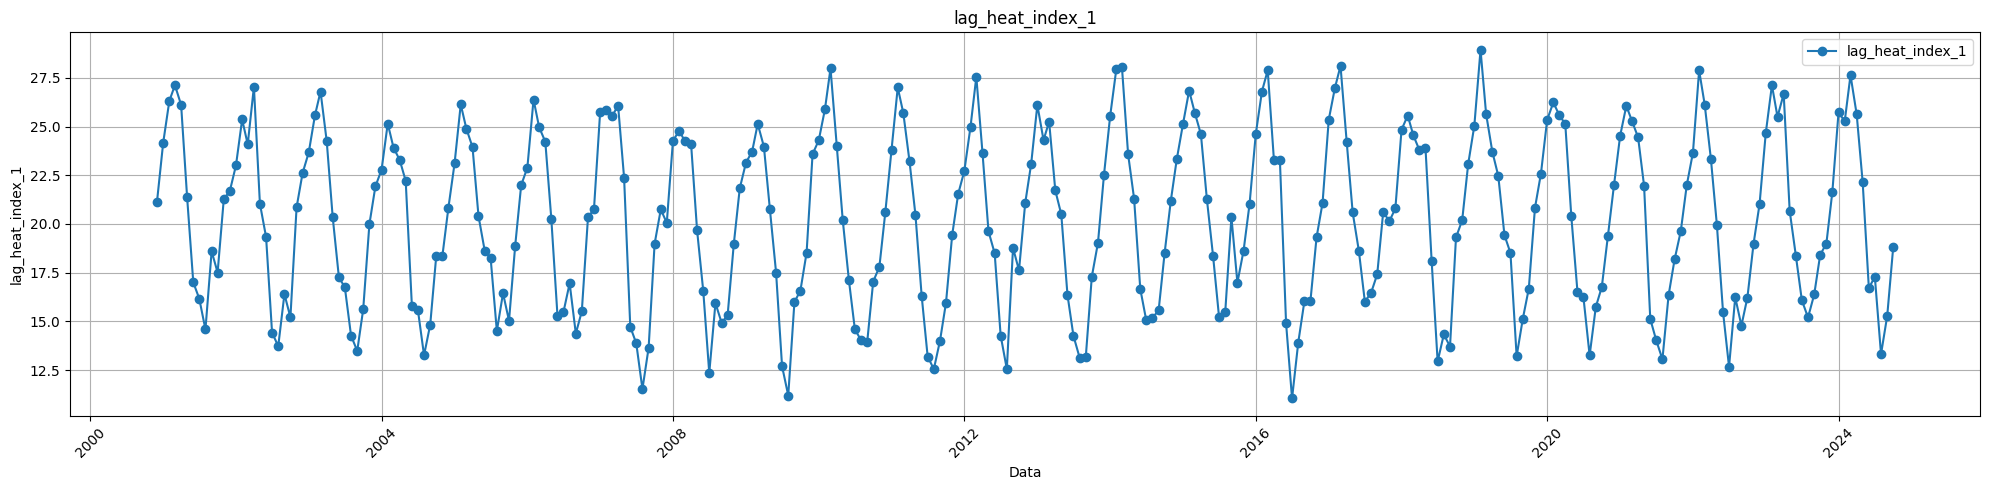

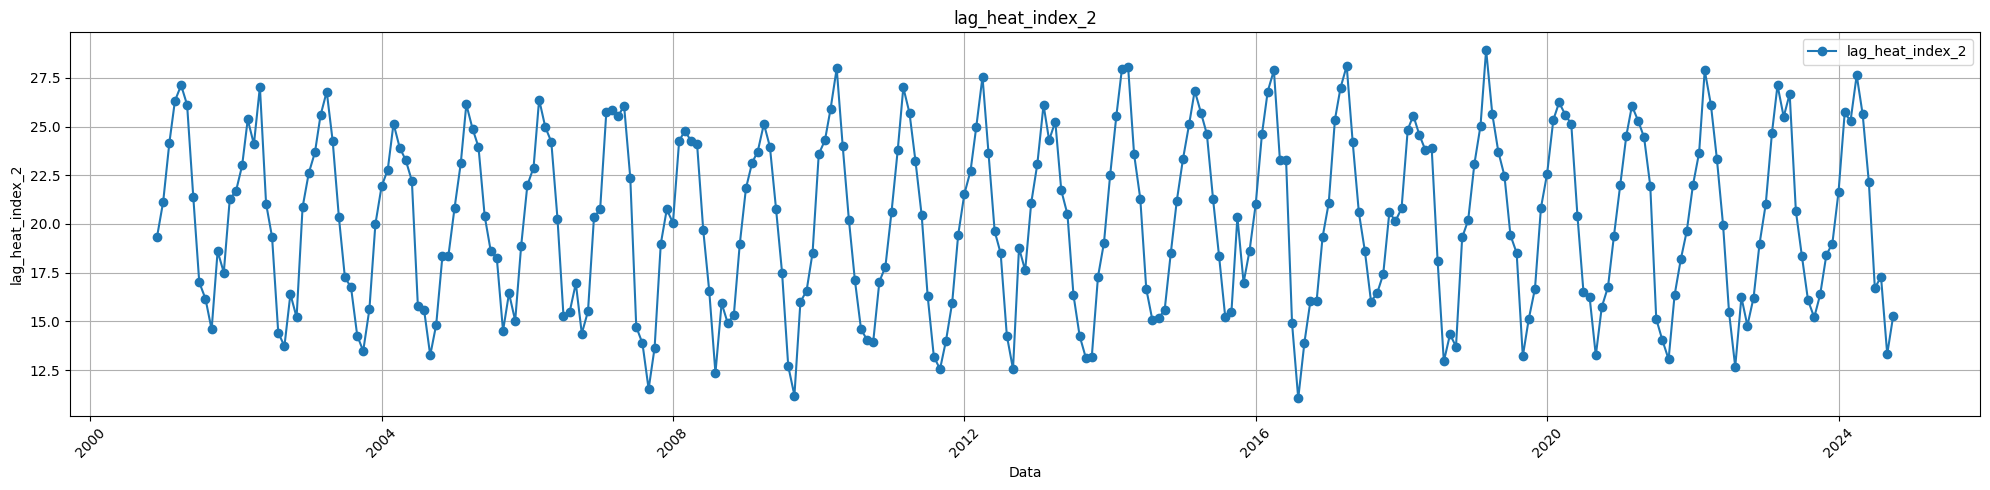

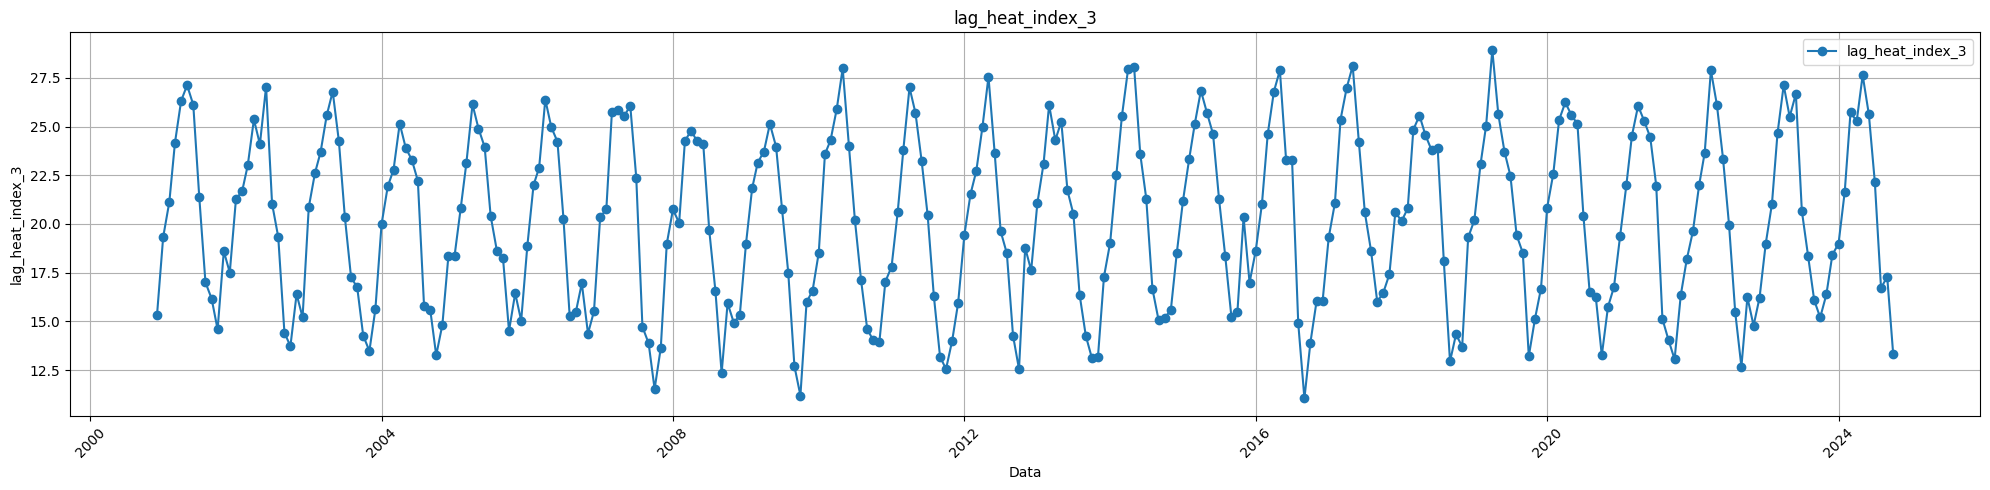

In [62]:
for variable in datasetINMET_m.columns:
    plt.figure(figsize=(20, 5))
    plt.plot(datasetINMET_m.index.to_timestamp(), datasetINMET_m[variable], marker='o', label=variable)
    plt.title(f'{variable}')
    plt.xlabel('Data')
    plt.ylabel(variable)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
